In [13]:
from model_layers import ConvEncoder, ConvDecoder, MLP, DummyImageVec
from utils import log_Normal_diag, get_normal_nll
import torch
import torch.nn as nn
import math
import torchvision
from torch.distributions import Normal, Bernoulli, Independent
from utils import (train_epoch, eval_model, train_model, load_dataset,
                   plot_training_curves, show_samples)
                   
import numpy as np
device = 'cuda'
from IWAE import IWAE

In [18]:

IMG_SIZE = (3, 32, 32)
model_dict = dict(K = 10,
             n_latent = 50,
                 input_shape = IMG_SIZE,
                  beta = 1, device = device)
model = IWAE(**model_dict).to(device)

In [19]:
train_loader, test_loader = load_dataset(img_size = IMG_SIZE, batch_size = 64, num_workers = 1, name="MNISTcolored")

In [20]:
train_dict = dict(model=model,
                  train_loader=train_loader,
                  test_loader=test_loader,
                  epochs=10,
                  lr=3e-4,
                  use_tqdm=True,
                  use_cuda=True)
train_losses, test_losses = train_model(**train_dict)

100%|██████████| 10/10 [21:13<00:00, 127.35s/it]


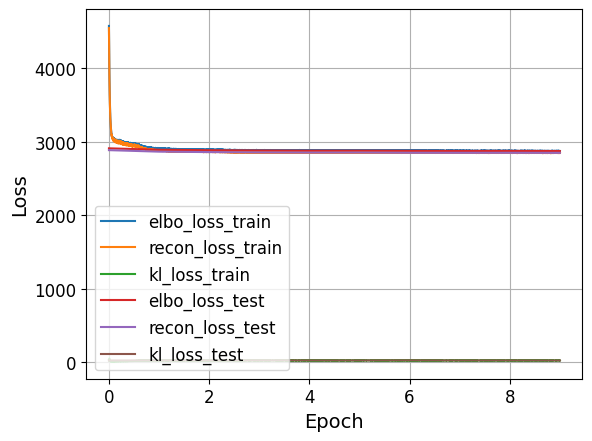

In [21]:
plot_training_curves(train_losses, test_losses)

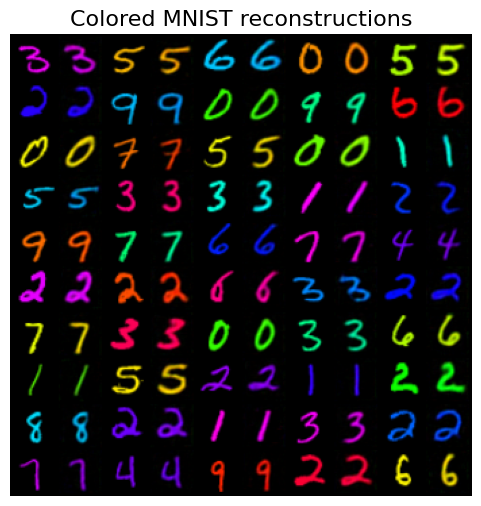

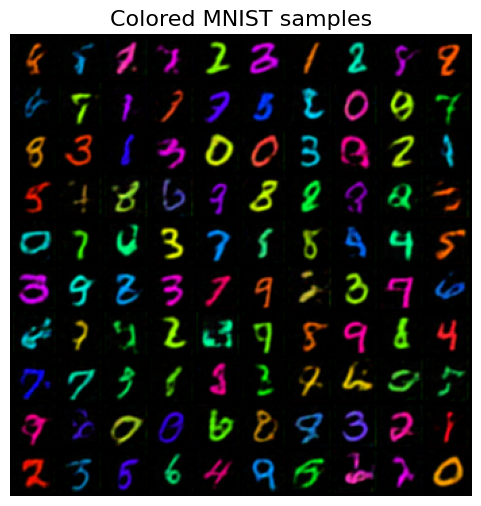

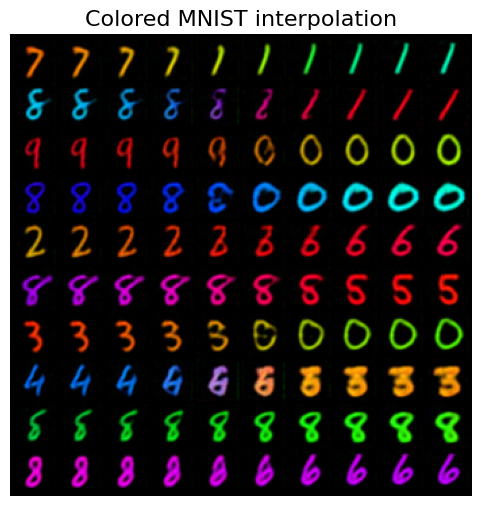

In [22]:
model.eval()
samples = model.sample(100)
USE_CUDA = device == 'cuda'
x, _ = next(iter(test_loader))
if USE_CUDA:
    x = x.cuda()[:50]

with torch.no_grad():
    z = model.encoder(x)[0]
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, *IMG_SIZE) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x, _ = next(iter(test_loader))
if USE_CUDA:
    x = x.cuda()[:20]

with torch.no_grad():
    z = model.encoder(x)[0]
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, *IMG_SIZE)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()


show_samples(reconstructions, 'Colored MNIST reconstructions')
show_samples(samples, 'Colored MNIST samples')
show_samples(interps, 'Colored MNIST interpolation')